In [1]:
import gc
import os
import torch
import warnings
import numpy as np
import pandas as pd
import back_testing as bt
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from lib.utils import load_pickle
from lib.algos.base import BaseConfig
from lib.arfnn import SimpleGenerator

gc.collect()
warnings.filterwarnings("ignore")

C:\Users\USER\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def estimate_VaR_ES(result_df, cl):
    VaR_array = result_df.apply(
        lambda col: np.percentile(col[pd.to_numeric(col, errors='coerce').notna()], cl)
        if col[pd.to_numeric(col, errors='coerce').notna()].size > 0 else np.nan,
        axis=0
    )
    mask = result_df.values[:, VaR_array.notna()] <= np.array(VaR_array.dropna())
    ES_array = np.where(mask, result_df.values[:, VaR_array.notna()], np.nan)
    ES_array = np.nanmean(ES_array, axis=0)
    return round(np.nanmean(VaR_array), 4), round(np.mean(ES_array), 4)


def simulate_rand_day(momentum_12m):
    random_idx = pd.to_datetime(np.random.choice(momentum_12m.index))
    rand_momentum_12m = momentum_12m.loc[random_idx:, :]
    weights = bt.dual_momentum_strategy(rand_momentum_12m)
    local_result = pd.DataFrame()
    local_result = bt.return_Table(weights, returns, local_result, True, 'Neutral', True, False)
    return local_result


def simulate_rand_company(price_df):
    random_cols = np.random.choice(price_df.columns, size=10, replace=False)
    df_ = price_df[random_cols]
    returns = bt.get_momentum(df_, 1)
    momentum_12m = bt.get_momentum(df_, 12)
    weights = bt.dual_momentum_strategy(momentum_12m)
    local_result = pd.DataFrame()
    local_result = bt.return_Table(weights, returns, local_result, True, 'Neutral', True, False)
    return local_result


def get_dataset_configuration(df_0):
    df_1 = df_0.dropna(axis=0)
    df_2 = df_1.pct_change().applymap(lambda x: np.log1p(x)).dropna()
    return df_2, np.array(df_2.mean()), np.array(df_2.std())

In [3]:
price_df = pd.read_csv('./data/sp500.csv')
price_df.set_index('datadate', inplace=True)
price_df.index = pd.to_datetime(price_df.index, format='%Y-%m-%d')

idx_df = pd.read_csv('./data/GSPC.csv', index_col='Date')
idx_df = idx_df.pct_change().apply(lambda x: np.log1p(x)).dropna()
idx_df.index = pd.to_datetime(idx_df.index, format='%Y-%m-%d')

df_ = price_df[['AAPL', 'DIS', 'XOM', 'INTC', 'MSFT', 'AMZN', 'NVDA', 'CRM', 'GOOGL', 'TSLA']]
r_log_real, mean, std = get_dataset_configuration(df_)
returns = bt.get_momentum(df_, 1)
momentum_12m = bt.get_momentum(df_, 12)

In [10]:
rand_day = True
if rand_day:
    results = Parallel(n_jobs=8)(delayed(simulate_rand_day)(momentum_12m) for _ in tqdm(range(1000)))
    result_df = pd.concat(results, axis=1)
    print(estimate_VaR_ES(result_df, 5))

100%|██████████| 1000/1000 [03:55<00:00,  4.24it/s]


(-0.0152, -0.0315)


In [5]:
rand_company = False
if rand_company:
    results = Parallel(n_jobs=8)(delayed(simulate_rand_company)(price_df) for _ in tqdm(range(1000)))
    result_df = pd.concat(results, axis=1)
    print(estimate_VaR_ES(result_df, 5))

In [34]:
MC = True
if MC:
    n_simulations = 3700
    n_assets = returns.shape[1]

    mu = returns.mean().values
    cov = returns.cov().values
    L = np.linalg.cholesky(cov)

    Z = np.random.normal(size=(n_simulations, n_assets))
    correlated_returns = Z @ L.T

    simulated_returns = correlated_returns + mu.reshape(1, -1)
    MC_ret_df = pd.DataFrame(simulated_returns, columns=returns.columns)

    initial_price = df_.dropna(axis=0).iloc[0, :]
    MC_pri_df = initial_price * (1 + MC_ret_df).cumprod(axis=0)

    fake_returns = bt.get_momentum(MC_pri_df, 1)
    fake_momentum_12m = bt.get_momentum(MC_pri_df, 12)
    result_df = pd.DataFrame()
    weights = bt.dual_momentum_strategy(fake_momentum_12m)
    result_df = bt.return_Table(weights, fake_returns, result_df, True, 'Neutral', True, False)

    print(estimate_VaR_ES(result_df, 5))

(-0.0282, -0.0372)


In [36]:
sig = True
if sig:
    device = 'cpu'
    experiment_dir = './numerical_results/VAR/stock/seed=0/SigCWGAN'
    base_config = BaseConfig(device=device)
    p, q = base_config.p, base_config.q
    x_real = load_pickle(os.path.join(os.path.dirname(experiment_dir), 'x_real_test.torch')).to(device)
    x_past, x_future = x_real[:, :p], x_real[:, p:p + q]
    dim = x_real.shape[-1]
    G_weights = load_pickle(os.path.join(experiment_dir, 'G_weights.torch'))
    G = SimpleGenerator(dim * p, dim, base_config.hidden_dims, dim).to(device)
    G.load_state_dict(G_weights)

    with torch.no_grad():
        x_fake = G.sample(3700, x_past[0:1])

    x_fake = x_fake.squeeze()
    x_fake = x_fake.cpu().detach().numpy()
    r_log_fake = x_fake * std + mean
    r_simple_fake = np.exp(r_log_fake) - 1  # shape: (10, T)

    sig_ret_df = pd.DataFrame(r_simple_fake, columns=returns.columns)

    initial_price = df_.dropna(axis=0).iloc[0, :]
    sig_pri_df = initial_price * (1 + sig_ret_df).cumprod(axis=0)

    fake_returns = bt.get_momentum(sig_pri_df, 1)
    fake_momentum_12m = bt.get_momentum(sig_pri_df, 12)
    result_df = pd.DataFrame()
    weights = bt.dual_momentum_strategy(fake_momentum_12m)
    result_df = bt.return_Table(weights, fake_returns, result_df, True, 'Neutral', True, False)

    print(estimate_VaR_ES(result_df, 5))

(-0.0417, -0.0643)


In [29]:
MC_ret_df

,AAPL,DIS,XOM,INTC,MSFT,AMZN,NVDA,CRM,GOOGL,TSLA
0,-0.0117,-0.0022,1.6826e-02,-0.0133,0.0132,0.0051,-0.0102,0.0264,0.0330,-0.0248
1,0.0178,0.0154,2.0007e-02,0.0189,0.0157,0.0572,0.0209,0.0449,0.0107,0.0894
2,0.0167,0.0044,-4.4801e-03,-0.0330,0.0013,-0.0166,0.0057,0.0301,0.0252,-0.1034
3,0.0162,-0.0078,1.1003e-02,0.0223,0.0038,-0.0065,-0.0201,-0.0149,-0.0046,0.0404
4,-0.0042,-0.0227,4.7368e-03,-0.0186,0.0133,-0.0087,-0.0032,-0.0161,0.0222,0.0329
...,...,...,...,...,...,...,...,...,...,...
9995,-0.0336,0.0013,5.5410e-03,-0.0050,-0.0006,0.0085,-0.0071,0.0102,-0.0219,-0.0312
9996,-0.0312,-0.0099,-1.3339e-02,-0.0132,-0.0116,-0.0256,-0.0209,0.0140,-0.0214,-0.0122
9997,0.0273,0.0027,1.7242e-03,-0.0021,0.0085,-0.0019,0.0205,0.0047,0.0183,0.0458
9998,0.0236,-0.0044,8.0242e-03,0.0111,0.0304,-0.0015,0.0250,0.0036,0.0079,0.0270


In [28]:
pd.DataFrame(r_simple_fake)

,0,1,2,3,4,5,6,7,8,9
0,0.0059,-0.0119,0.0048,-0.0023,0.0012,-0.0261,-0.0126,-0.0489,-0.0052,-4.7304e-03
1,-0.0065,0.0019,-0.0023,-0.0049,-0.0070,-0.0080,-0.0069,-0.0211,0.0079,5.7779e-02
2,0.0612,0.0265,0.0634,0.0581,0.0407,0.0648,0.0723,0.0423,0.0804,9.2816e-02
3,-0.0558,-0.0322,-0.0598,-0.0495,-0.0426,-0.0550,-0.0795,-0.0573,-0.0855,1.6204e-02
4,0.0293,0.0014,0.0182,0.0232,0.0294,0.0805,0.0778,0.0513,0.0691,1.1264e-02
...,...,...,...,...,...,...,...,...,...,...
1095,-0.0078,-0.0023,0.0119,-0.0100,-0.0020,0.0116,-0.0088,-0.0057,0.0027,2.9802e-02
1096,0.0010,-0.0093,-0.0188,-0.0054,-0.0063,-0.0099,-0.0167,0.0054,-0.0148,-1.8661e-02
1097,0.0204,-0.0012,0.0046,0.0039,0.0060,0.0377,0.0273,0.0294,0.0252,-1.2133e-03
1098,0.0138,-0.0074,0.0010,-0.0088,0.0089,0.0147,0.0572,0.0219,0.0146,4.1406e-05


In [4]:
col_lst=['prccd', 'cshtrd', 'absacc', 'acc', 'aeavol', 'agr', 'baspread', 'beta', 'cashpr', 'cfp', 'chmom', 'chtx',
         'ear', 'retvol', 'tb', 'turn']

In [24]:
# ROOT_DIR = './data/monthly_pricewithcharacteristics'
# fake_dict={}
# for tic in tqdm(os.listdir(ROOT_DIR)):
#     """ Create the experiment directory, calibrate algorithm, store relevant parameters. """
#     company = tic.split('.')[0]
#     experiment_dir = f'./numerical_results/{company}/stock/seed=0/SigCWGAN'
#     device = 'cpu'
#     base_config = BaseConfig(device=device)
#     p, q = base_config.p, base_config.q
#     x_real = load_pickle(os.path.join(os.path.dirname(experiment_dir), 'x_real_test.torch')).to(device)
#     x_past, x_future = x_real[:, :p], x_real[:, p:p + q]
#     dim = x_real.shape[-1]
#     G_weights = load_pickle(os.path.join(experiment_dir, 'G_weights.torch'))
#     G = SimpleGenerator(dim * p, dim, base_config.hidden_dims, dim).to(device)
#     G.load_state_dict(G_weights)
#
#     with torch.no_grad():
#         x_fake = G.sample(10000, x_past[0:1])
#
#     x_fake = x_fake.squeeze()
#     x_fake = x_fake.cpu().detach().numpy()
#     fake_dict[company] = pd.DataFrame(x_fake, columns=col_lst)

In [6]:
import matplotlib.pyplot as plt

def plot_generator_weights(generator):
    for name, module in generator.named_modules():
        if isinstance(module, torch.nn.Linear):
            weights = module.weight.data.cpu().numpy().flatten()

            plt.figure(figsize=(6, 3))
            plt.hist(weights, bins=50, alpha=0.7)
            plt.title(f'Weight Distribution - {name}')
            plt.xlabel('Weight value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.tight_layout()
            plt.show()


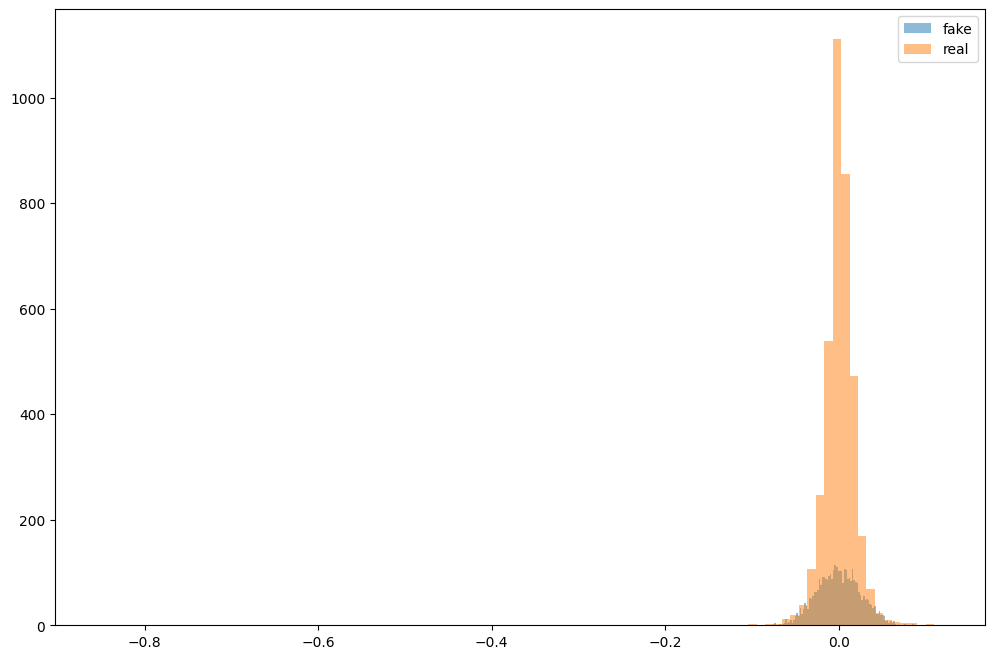

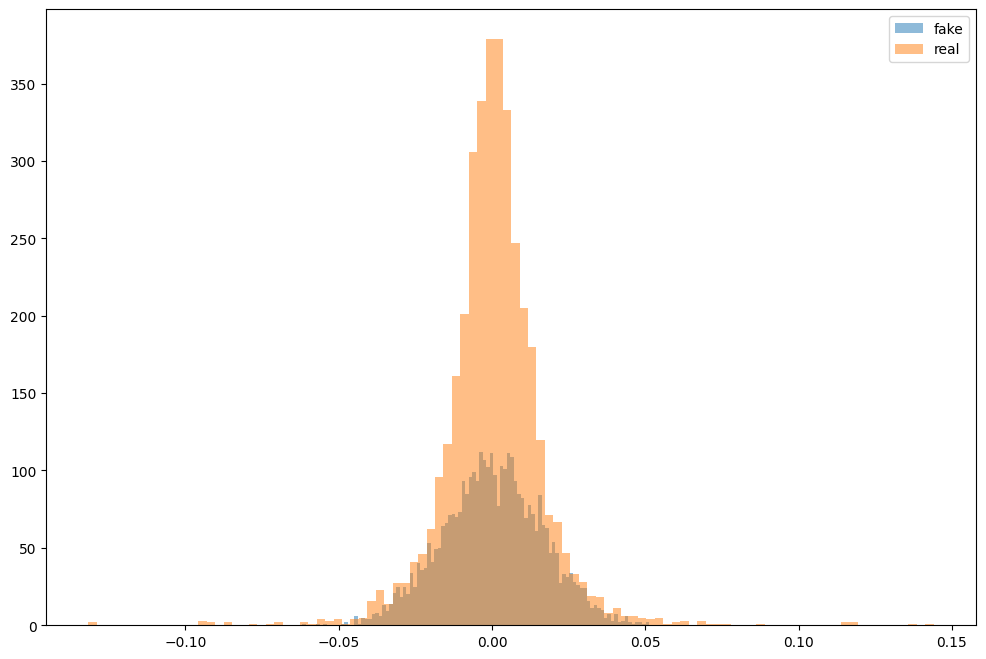

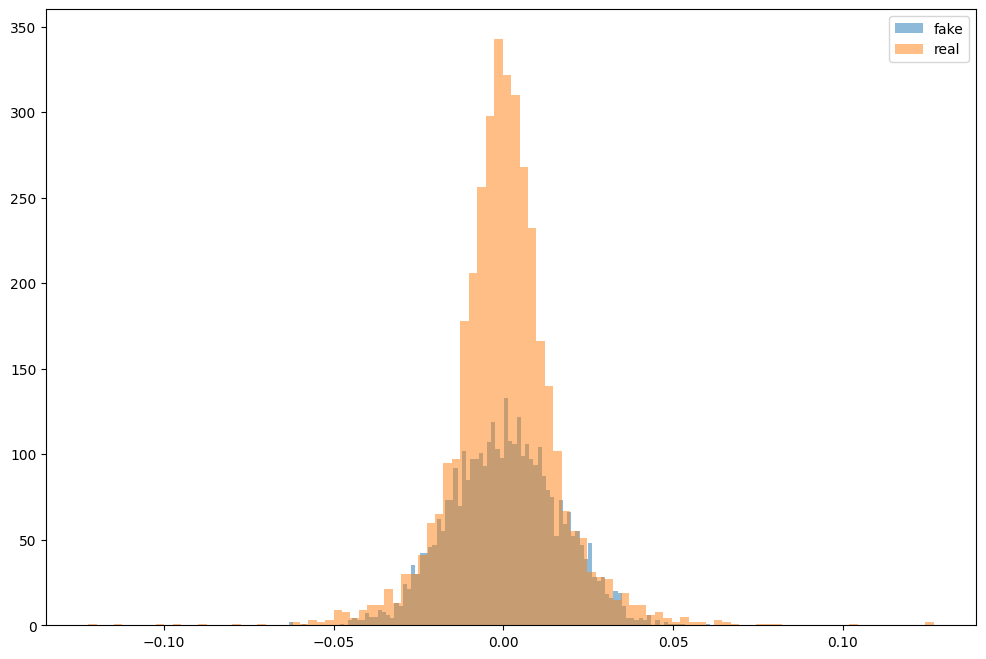

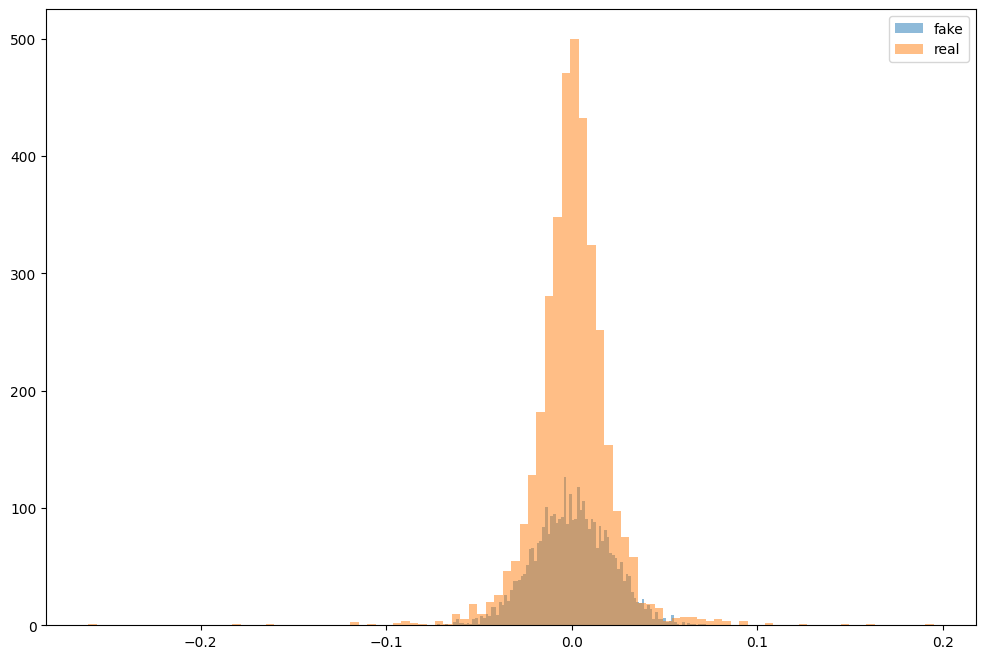

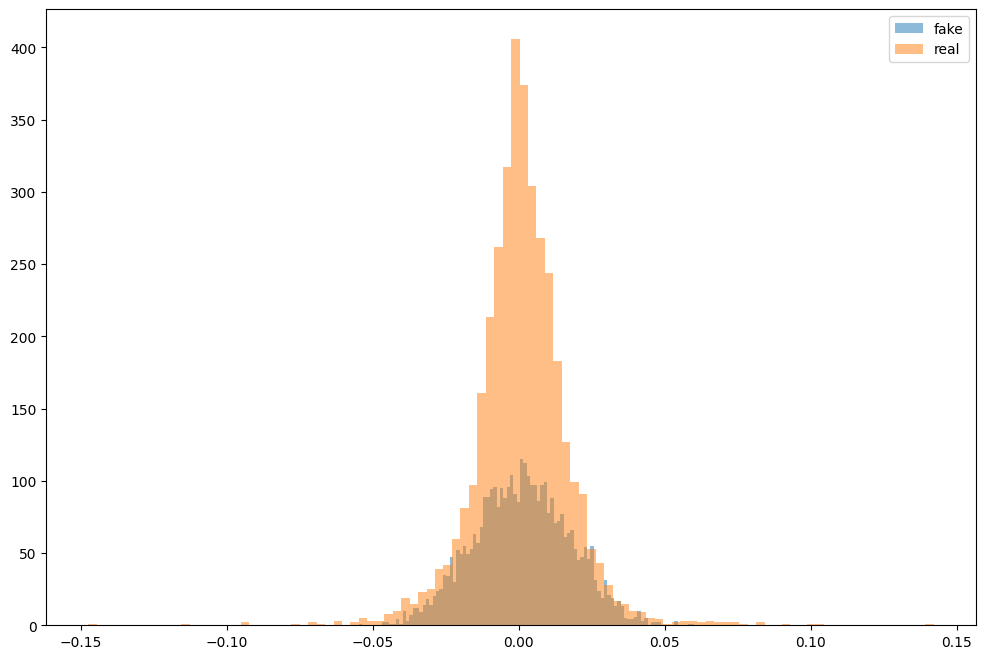

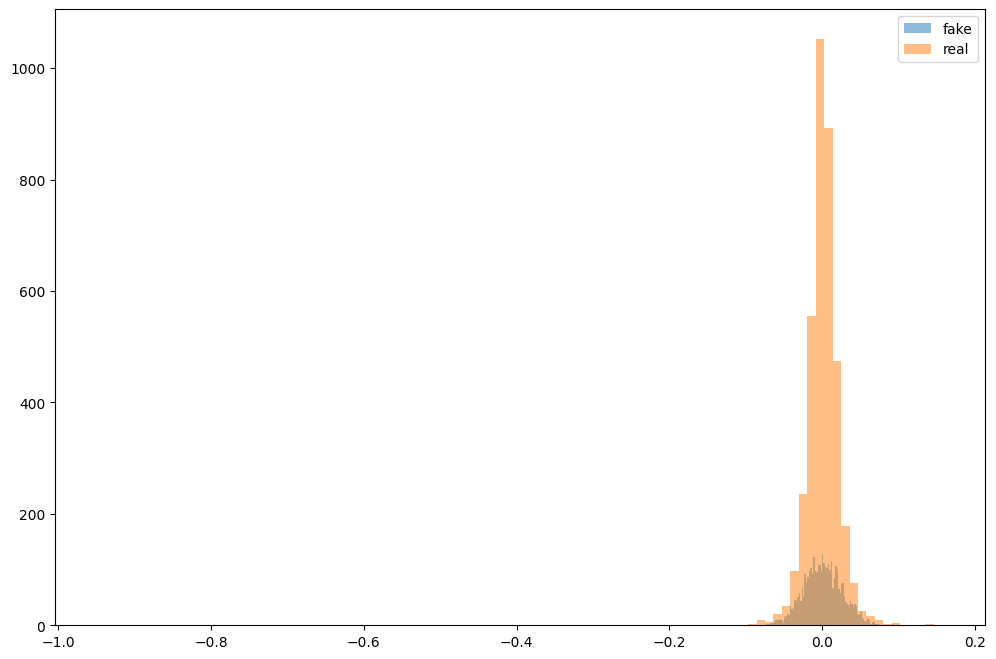

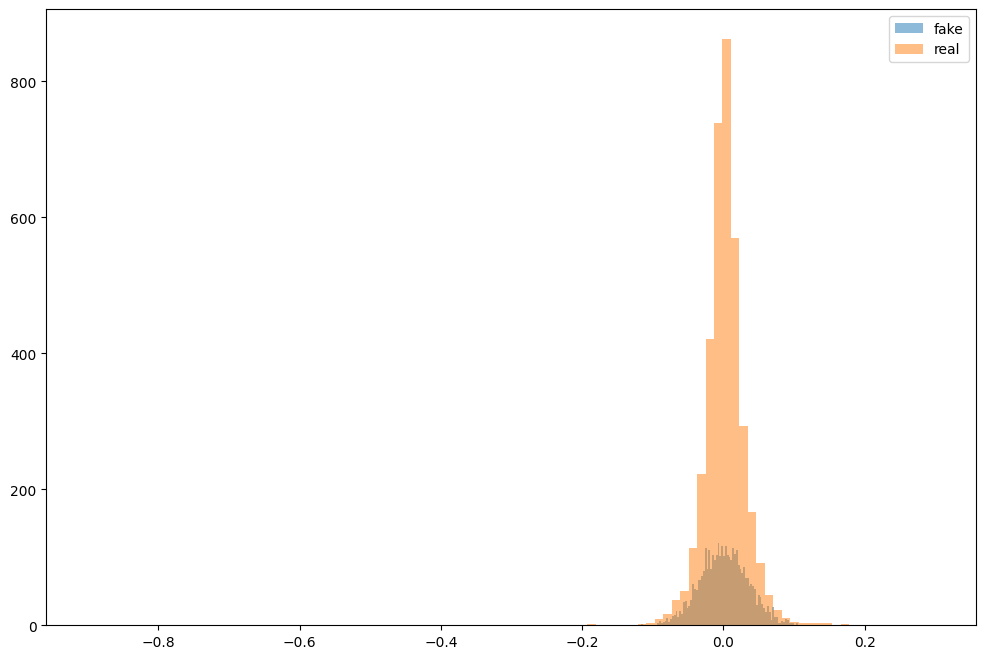

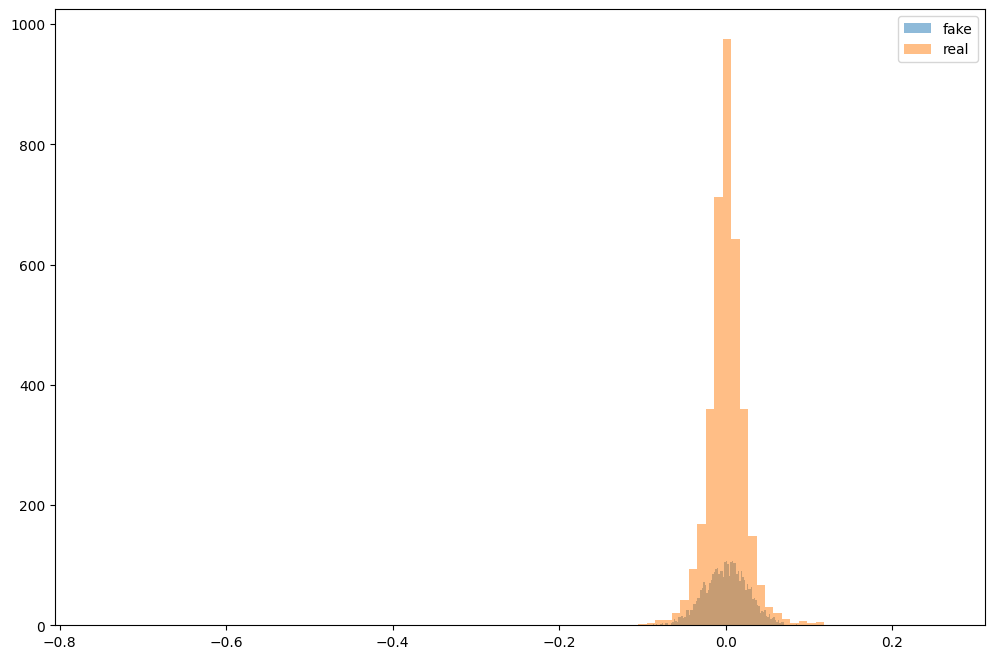

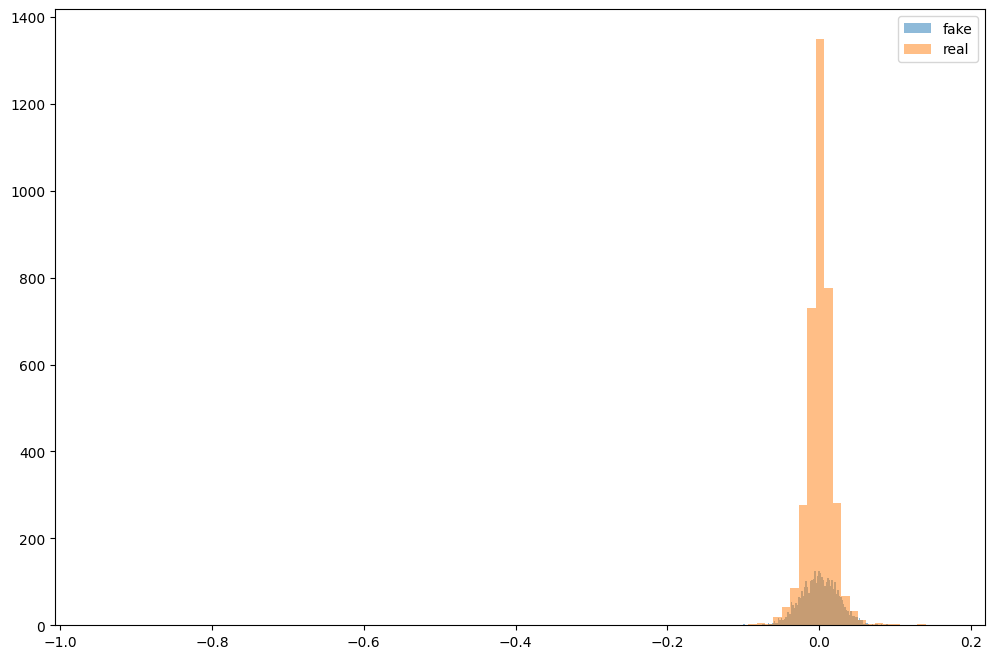

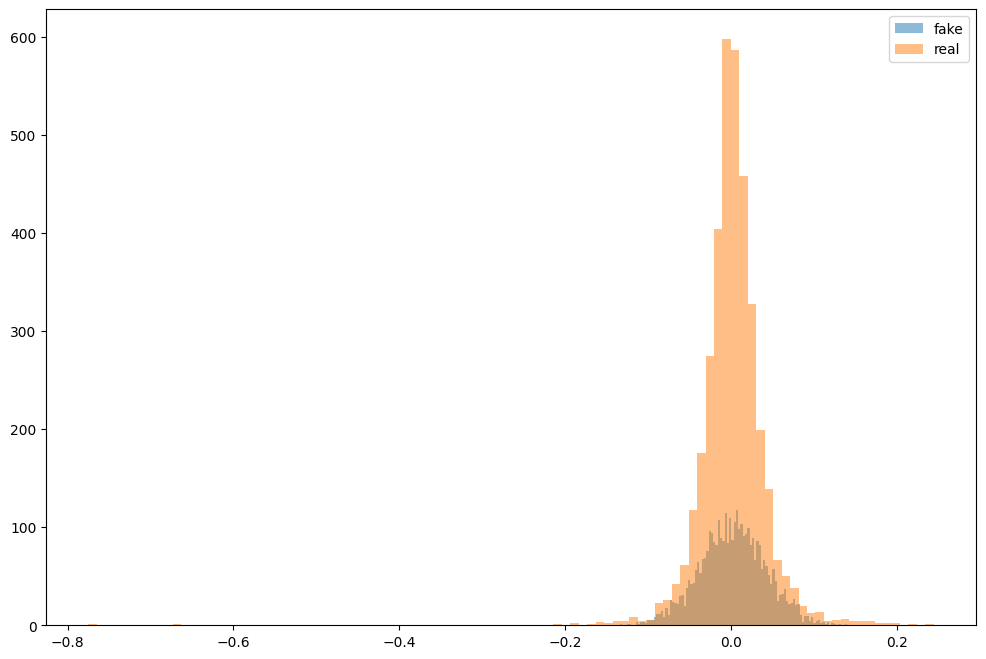

In [37]:
for i in range(10):
    plt.figure(figsize=(12, 8))
    plt.hist(MC_ret_df.values[:, i], bins=100, label='fake', alpha=0.5)
    plt.hist(r_log_real.iloc[:, i].apply(lambda x: np.exp(x) - 1), bins=100, label='real', alpha=0.5)
    plt.legend()
    plt.show()

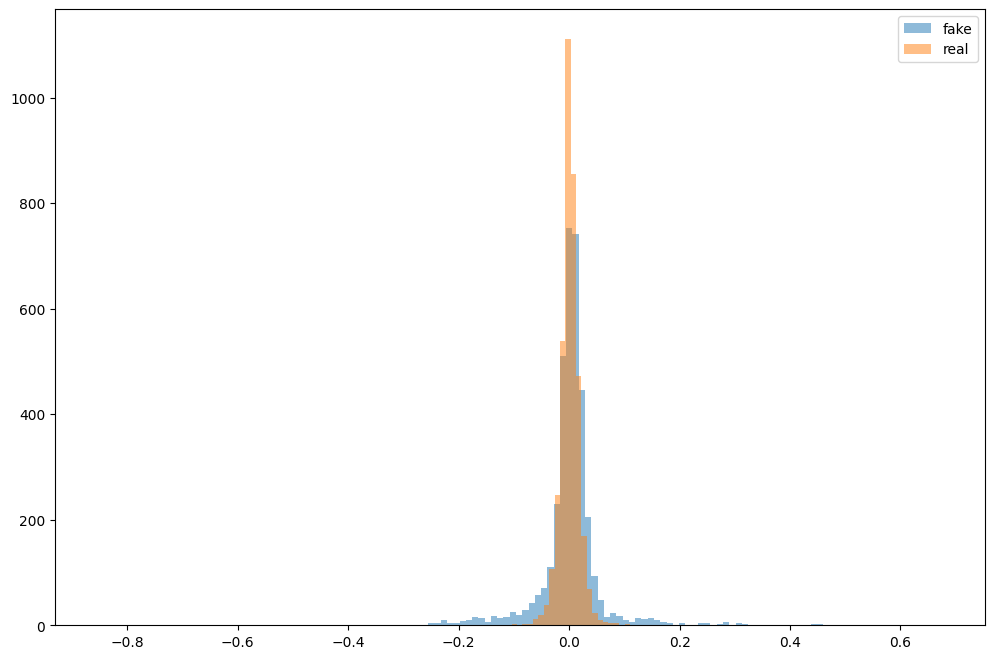

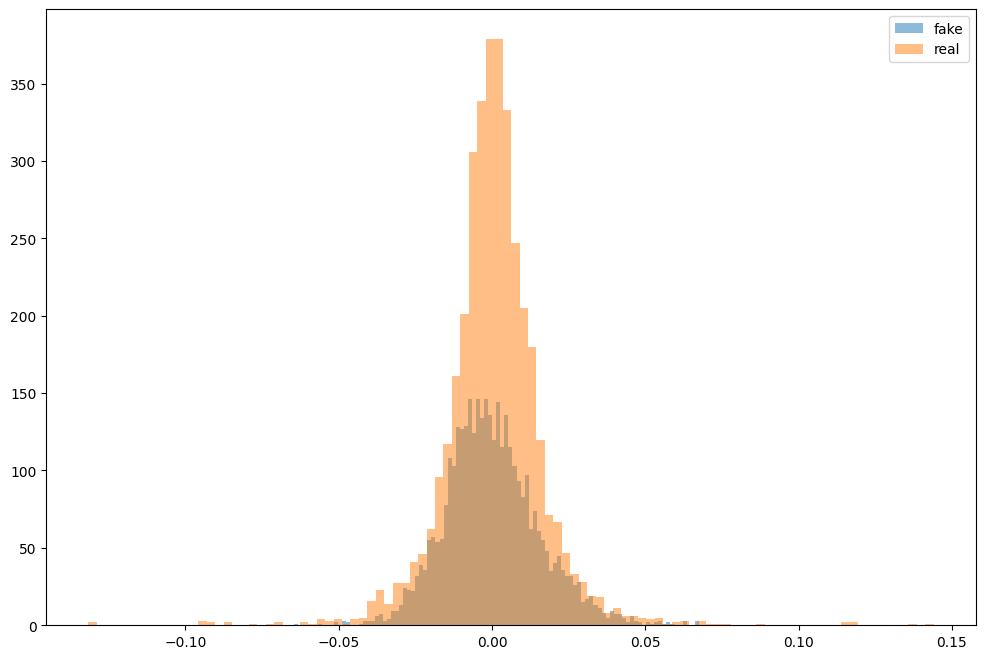

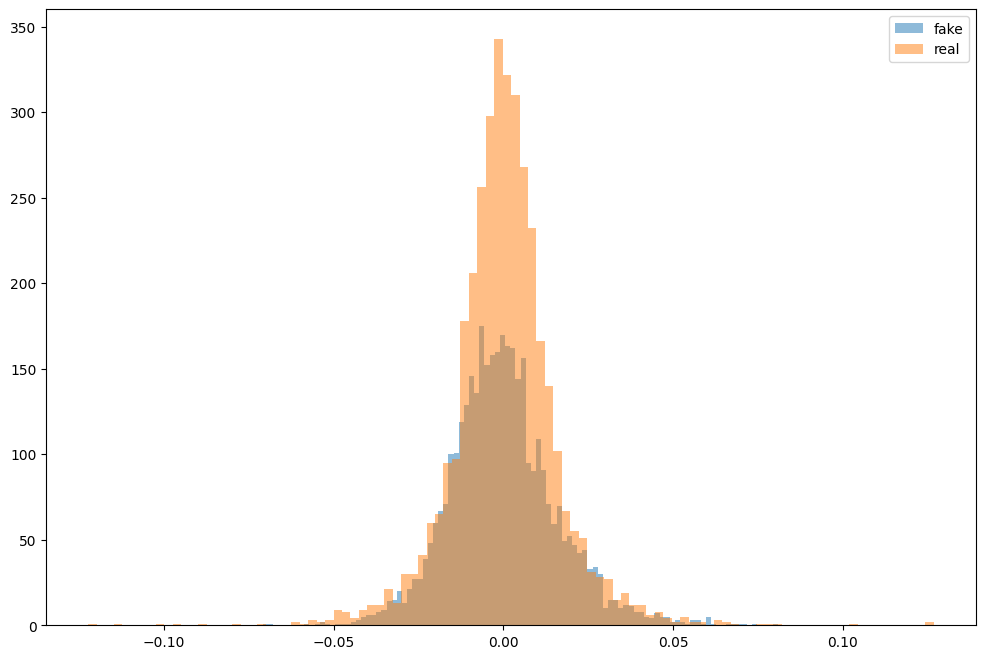

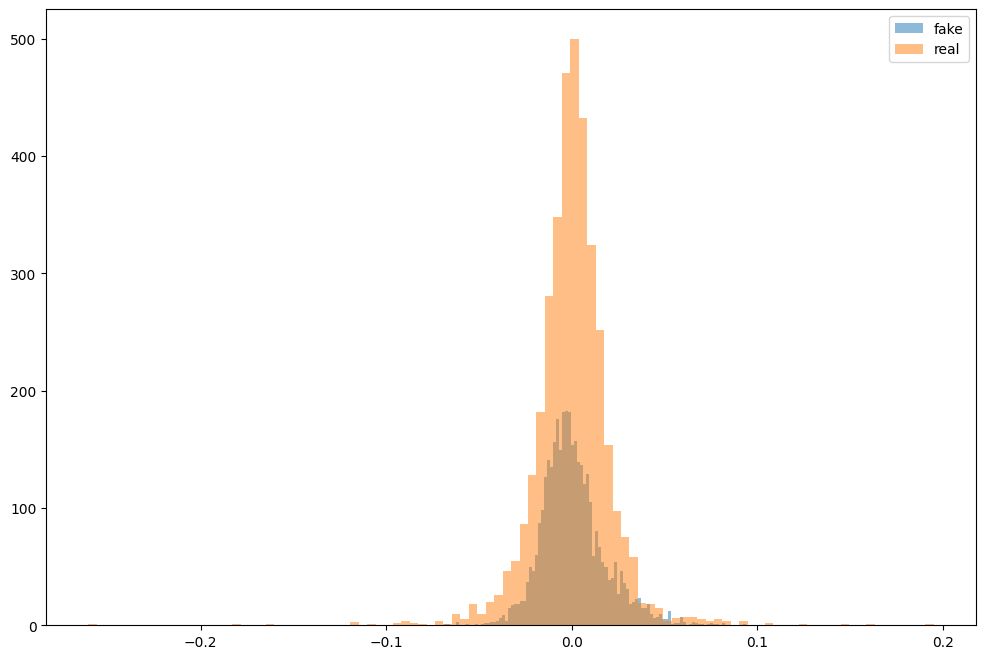

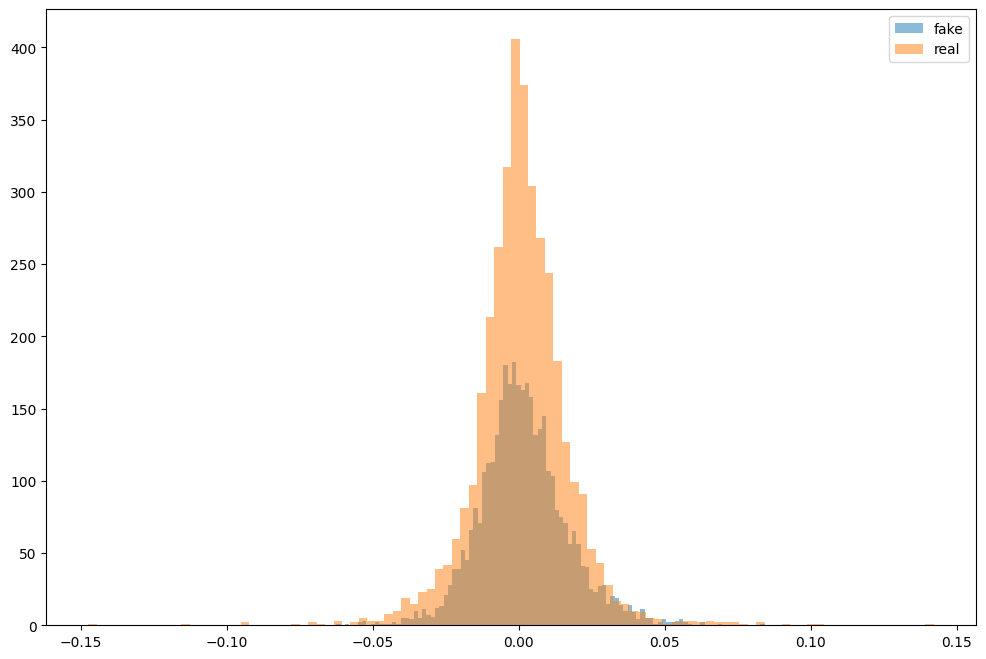

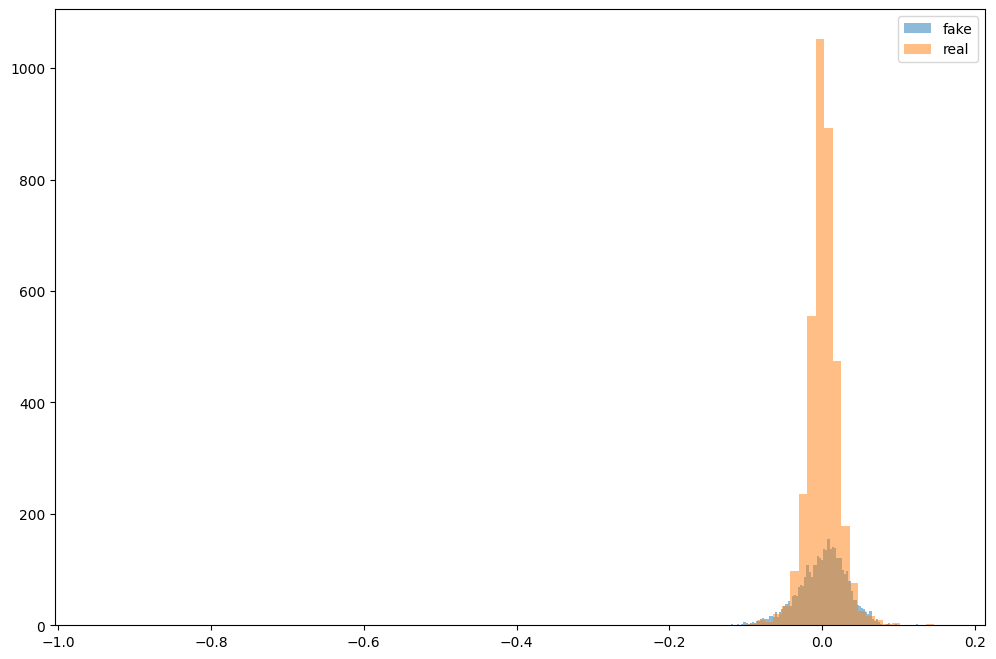

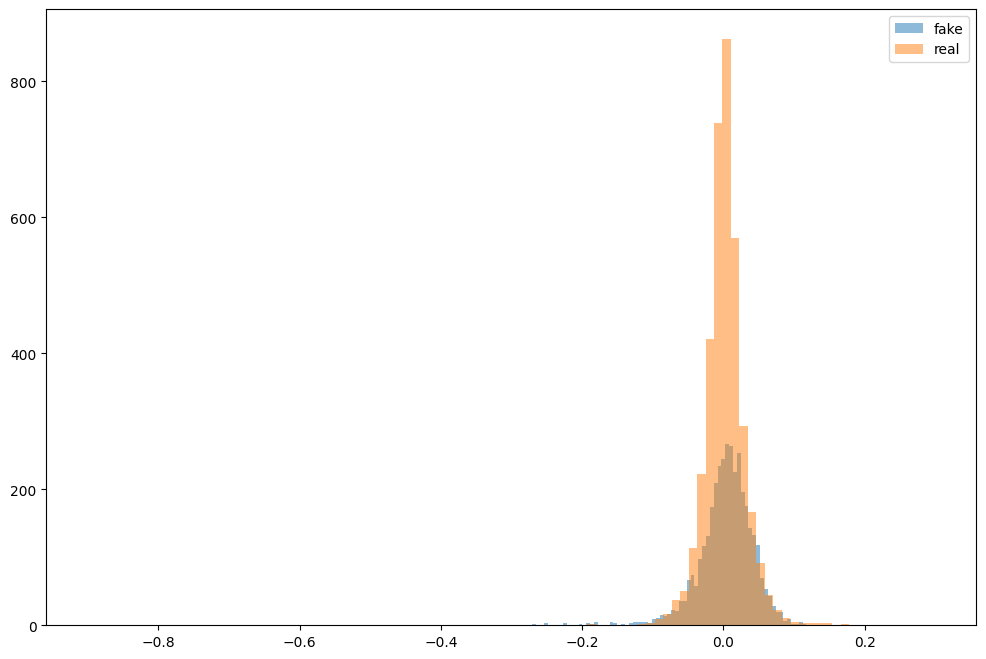

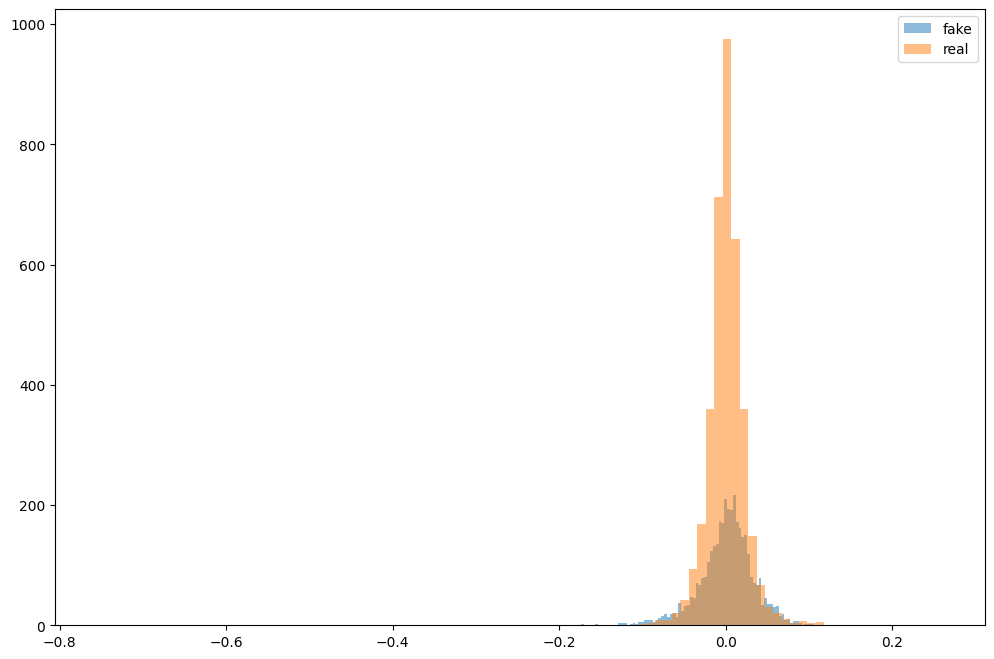

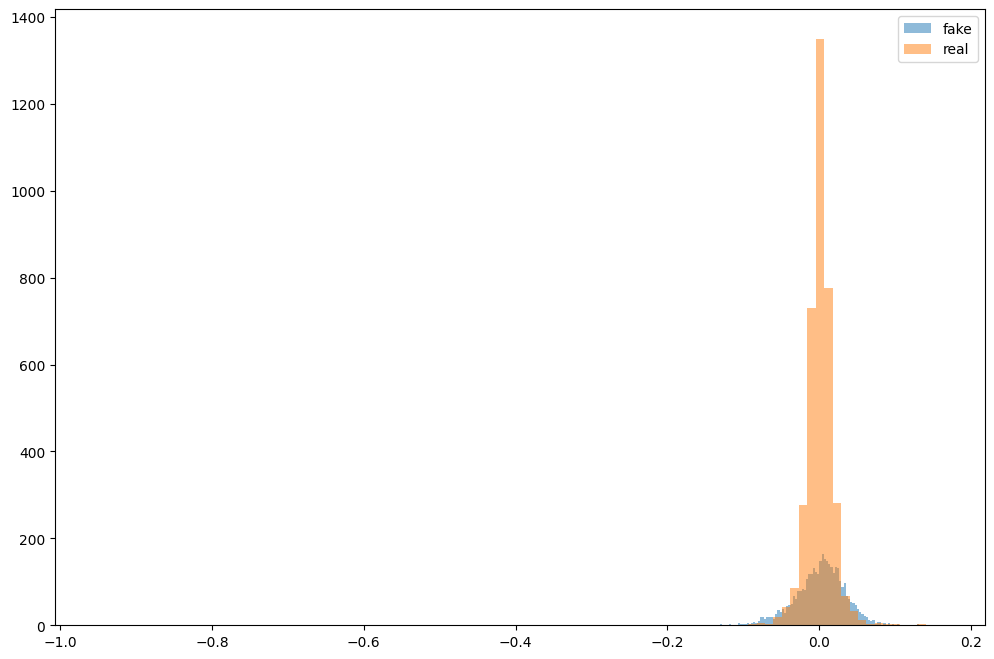

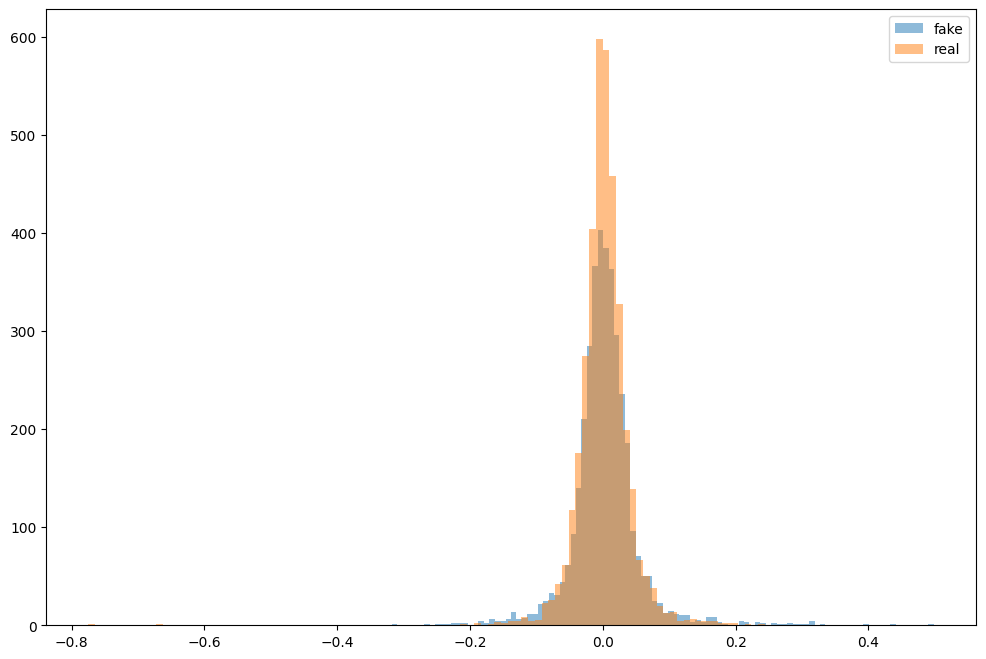

In [38]:
for i in range(10):
    plt.figure(figsize=(12, 8))
    plt.hist(r_simple_fake[:, i], bins=100, label='fake', alpha=0.5)
    plt.hist(r_log_real.iloc[:, i].apply(lambda x: np.exp(x) - 1), bins=100, label='real', alpha=0.5)
    plt.legend()
    plt.show()